In [2]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy import stats

# 統計モデルを推定するライブラリ
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# グラフを描画するライブラリ
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set()

# 動的なグラフを描画するライブラリ
import plotly.express as px

# sktimeで状態空間モデルを推定する
from sktime.forecasting.structural import UnobservedComponents

# グラフの日本語表記
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

In [3]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [4]:
# 日単位データの読み込み
sales_day = pd.read_csv(
    "5-6-1-daily-sales-data.csv", index_col="date", parse_dates=True, dtype="float"
)
sales_day.index.freq = "D"

# 結果の確認
print(sales_day.head(3))
print(sales_day.tail(3))

                 sales  flyer
date                         
2000-01-01  462.387217    0.0
2000-01-02  363.262237    0.0
2000-01-03  356.648654    0.0
                 sales  flyer
date                         
2001-06-27  243.739643    0.0
2001-06-28  205.223214    0.0
2001-06-29  192.051090    0.0


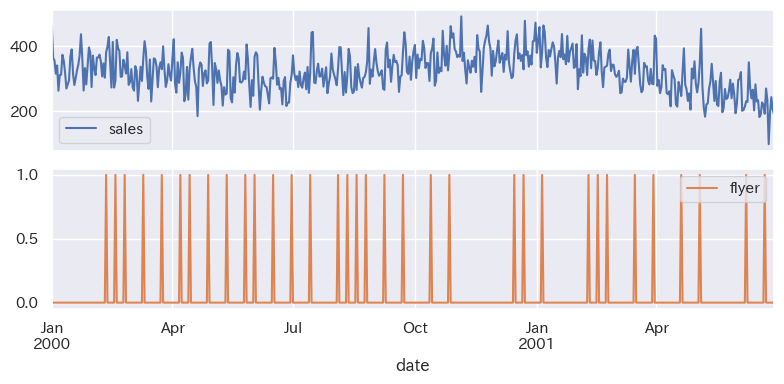

In [5]:
# 可視化
sales_day.plot(subplots=True)
plt.tight_layout()

In [6]:
# 参考：動的なグラフ
px.line(sales_day.sales)

In [7]:
# カレンダー情報を入れたデータ
sales_day_eda = sales_day.copy()

# 月
sales_day_eda["month"] = sales_day_eda.index.month

# 曜日
sales_day_eda["weekday"] = sales_day_eda.index.weekday

# 結果の確認
print(sales_day_eda.head(3))

                 sales  flyer  month  weekday
date                                         
2000-01-01  462.387217    0.0      1        5
2000-01-02  363.262237    0.0      1        6
2000-01-03  356.648654    0.0      1        0


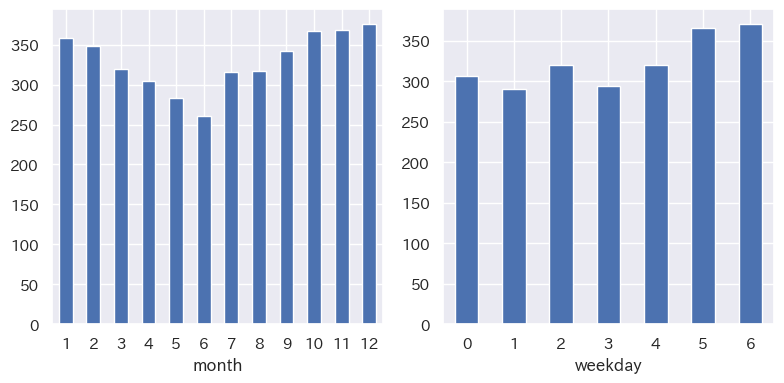

In [8]:
# 2列のグラフ
fig, ax = plt.subplots(ncols=2, tight_layout=True)

# 月ごとの売り上げ比較
sales_day_eda.groupby("month").mean()["sales"].plot(kind="bar", ax=ax[0])

# 曜日ごとの売り上げ比較
sales_day_eda.groupby("weekday").mean()["sales"].plot(kind="bar", ax=ax[1])

# X軸ラベルを回転させないようにする
ax[0].xaxis.set_tick_params(rotation=0)
ax[1].xaxis.set_tick_params(rotation=0)

In [9]:
# チラシの有無別売り上げ平均値
sales_day_eda.groupby("flyer").mean()["sales"]

flyer
0.0    324.384704
1.0    320.663946
Name: sales, dtype: float64

In [10]:
# ラグ特徴量の作成
# flyer_lag1: 1日前のチラシ配布（前日）
# flyer_lag2: 2日前のチラシ配布（前々日）
sales_day_eda["flyer_lag1"] = sales_day_eda["flyer"].shift(1).fillna(0)
sales_day_eda["flyer_lag2"] = sales_day_eda["flyer"].shift(2).fillna(0)

# 前日または前々日にチラシを配布した場合とそうでない場合で、
# 平均売上を比較する
print(sales_day_eda.groupby("flyer_lag1").mean()["sales"])
print(sales_day_eda.groupby("flyer_lag2").mean()["sales"])

flyer_lag1
0.0    319.717045
1.0    390.953406
Name: sales, dtype: float64
flyer_lag2
0.0    320.347595
1.0    381.458064
Name: sales, dtype: float64


In [11]:
# チラシをいつ配っているか
sales_day_eda.groupby("weekday").sum()["flyer"]

weekday
0     0.0
1     0.0
2     0.0
3     0.0
4    34.0
5     0.0
6     0.0
Name: flyer, dtype: float64

In [12]:
# ラグ特徴量を加える
# flyer_lag1: 1日前（前日）のチラシ配布有無
# flyer_lag2: 2日前（前々日）のチラシ配布有無
sales_day["flyer_lag1"] = sales_day["flyer"].shift(1).fillna(0)
sales_day["flyer_lag2"] = sales_day["flyer"].shift(2).fillna(0)

# 結果の確認
print(sales_day.loc["2000-02-17":"2000-02-21"])

                 sales  flyer  flyer_lag1  flyer_lag2
date                                                 
2000-02-17  273.073148    0.0         0.0         0.0
2000-02-18  295.044613    1.0         0.0         0.0
2000-02-19  419.312910    0.0         1.0         0.0
2000-02-20  393.584443    0.0         0.0         1.0
2000-02-21  385.480800    0.0         0.0         0.0


In [13]:
# 祝日を内閣府のWebサイトから読み込む
holiday = pd.read_csv(
    "https://www8.cao.go.jp/chosei/shukujitsu/syukujitsu.csv",
    encoding="CP932",  # 日本語（Shift_JIS）に対応する文字コード
    parse_dates=True,  # 日付をdatetime型に自動変換
    index_col=0,  # 日付列をインデックスとして扱う
)

# 結果の確認
print(holiday.head(3))

           国民の祝日・休日名称
国民の祝日・休日月日           
1955-01-01         元日
1955-01-15       成人の日
1955-03-21       春分の日


In [14]:
# 祝日フラグ
is_holiday = sales_day.index.isin(holiday.index).astype(int)

# 三が日と年末は祝日扱いにする
y_st = (sales_day.index.month == 1) & sales_day.index.day.isin([2, 3])
y_en = (sales_day.index.month == 12) & sales_day.index.day.isin([30, 31])
is_holiday = is_holiday + y_st + y_en

# データフレームにまとめる
sales_day["holiday"] = is_holiday

# 結果の確認
print(sales_day.head(3))

                 sales  flyer  flyer_lag1  flyer_lag2  holiday
date                                                          
2000-01-01  462.387217    0.0         0.0         0.0        1
2000-01-02  363.262237    0.0         0.0         0.0        1
2000-01-03  356.648654    0.0         0.0         0.0        1


In [15]:
# 日曜日かつ祝日の日は、通常の祝日と区別する
sales_day["sun_holiday"] = is_holiday & (sales_day.index.dayofweek == 6)

# 結果の確認
print(sales_day.head(3))

                 sales  flyer  flyer_lag1  flyer_lag2  holiday  sun_holiday
date                                                                       
2000-01-01  462.387217    0.0         0.0         0.0        1            0
2000-01-02  363.262237    0.0         0.0         0.0        1            1
2000-01-03  356.648654    0.0         0.0         0.0        1            0


In [16]:
# 季節変動ありの平滑化トレンドモデル
mod_bsts_1 = tsa.UnobservedComponents(
    sales_day["sales"],  # 対象データ
    level="smooth trend",  # 平滑化トレンド（local linear trendより滑らか）
    seasonal=7,  # 7日周期（週ごとの繰り返しを想定）
    exog=sales_day[
        [
            "holiday",
            "sun_holiday",  # 外生変数（イベント・販促効果）
            "flyer",
            "flyer_lag1",
            "flyer_lag2",
        ]
    ],
)

# 最尤法によるパラメータの推定
res_bsts_1 = mod_bsts_1.fit(
    method="nm",  # Nelder–Mead法による最適化（非線形パラメータ推定）
    maxiter=5000,  # 反復回数を増やし、収束を安定化
)

Optimization terminated successfully.
         Current function value: 4.954074
         Iterations: 1672
         Function evaluations: 2474


In [17]:
print(res_bsts_1.params)

sigma2.irregular    1237.337361
sigma2.trend           0.005019
sigma2.seasonal        0.001131
beta.holiday          54.939875
beta.sun_holiday     -89.121114
beta.flyer            -5.851354
beta.flyer_lag1       58.599129
beta.flyer_lag2       27.070706
dtype: float64


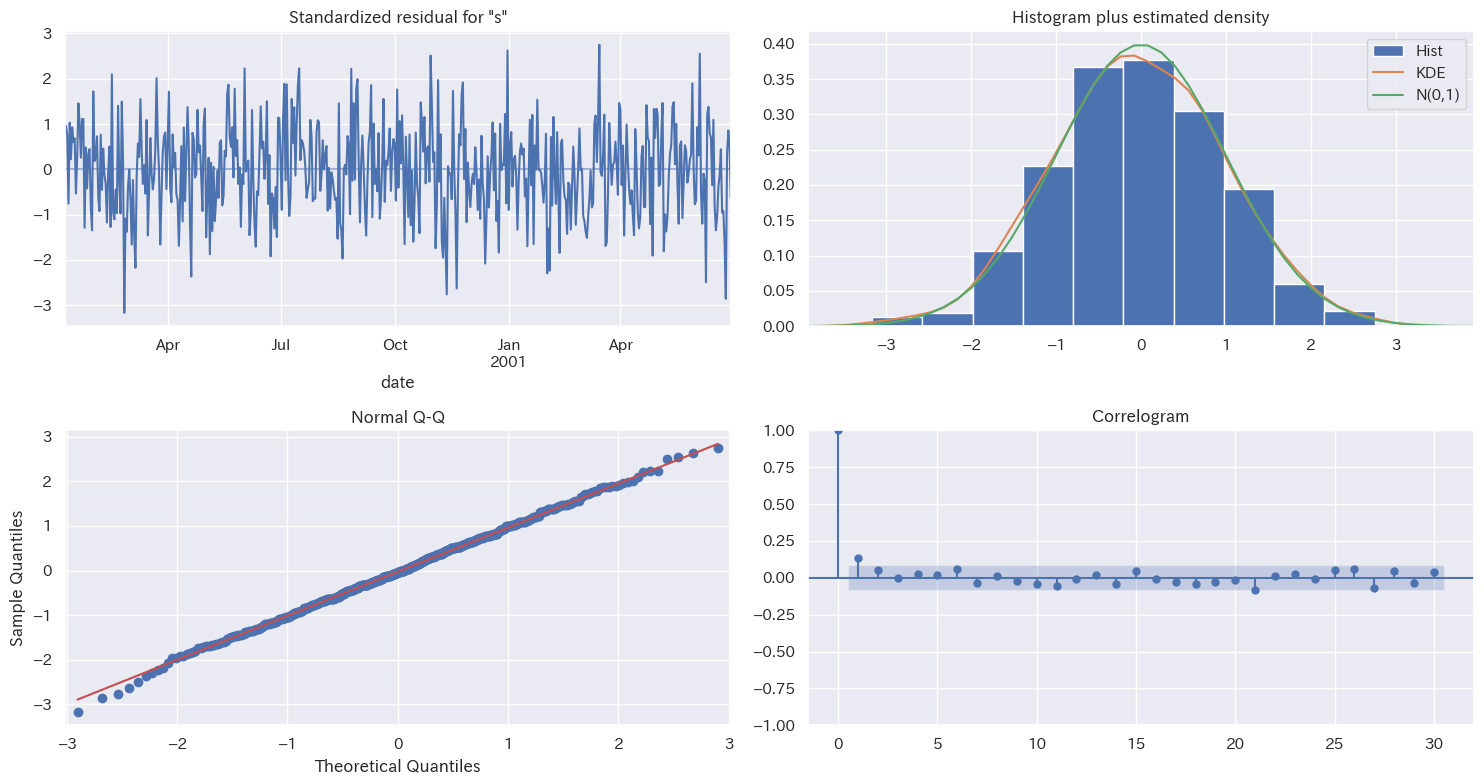

In [18]:
# 残差のチェック
_ = res_bsts_1.plot_diagnostics(
    lags=30, fig=plt.figure(tight_layout=True, figsize=(15, 8))
)

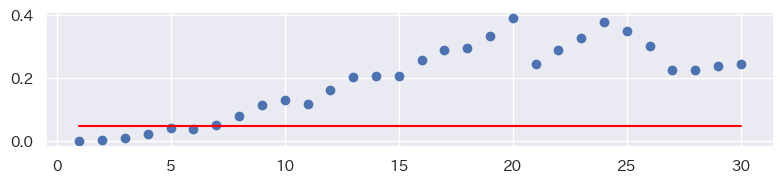

In [19]:
# 1時点前から30時点前まで、1つずつ最大次数をずらして、30回検定を行う
res_test = res_bsts_1.test_serial_correlation(method="ljungbox", lags=30)

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)

# p値のグラフを描画
ax.scatter(np.arange(1, 31), res_test[0][1])

# 高さ0.05の位置に赤線を引く
ax.plot(np.arange(1, 31), np.tile(0.05, 30), color="red")